# Pendulum RL Demo: Hyperparameter Optimization with Meta Ax

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/reinforcement-learning-demos/blob/main/rl-demo-pendulum-ax-hpo.ipynb)

This example demonstrates Bayesian Optimization to find good hyperparameters using [Meta Ax](https://ax.dev/). Trial results are saved to [Weights & Biases](https://wandb.ai/site) so you can remotely watch training in real-time and later review the hyperparameters for each trial. We use the basic [gymnasium pendulum environment](https://gymnasium.farama.org/environments/classic_control/pendulum/) and [PPO from stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) as our reinforcement learning agent.

Start with [this pendulum demo](https://github.com/ShawnHymel/reinforcement-learning-demos/blob/main/rl-demo-pendulum.ipynb) to see how RL training works. In that example, we pull hyperparameters from a known-good source ([rl-baselines3-zoo](https://github.com/DLR-RM/rl-baselines3-zoo)). But what happens when you don't have good hyperparameters to start with? RL can be tricky and vary wildly depending on what hyperparameters you use. So, hyperparameter tuning is very important. We use a combination of Ax (for Bayesian Optimization) and W&B (for experiment logging) to show how autotuning can be done (especially when model training is computationally expensive and time-consuming).

In [1]:
# !python -m pip install gymnasium==0.28.1
# !python -m pip install stable-baselines3[extra]==2.1.0
# !python -m pip install ax-platform==0.3.4
# !python -m pip install wandb==0.15.12

In [2]:
# Check versions
import importlib.metadata

print(f"torch version: {importlib.metadata.version('torch')}")
print(f"gymnasium version: {importlib.metadata.version('gymnasium')}")
print(f"sb3 version: {importlib.metadata.version('stable-baselines3')}")
print(f"cv2 version: {importlib.metadata.version('opencv-python')}")
print(f"ax version: {importlib.metadata.version('ax-platform')}")

torch version: 2.0.0
gymnasium version: 0.28.1
sb3 version: 2.1.0
cv2 version: 4.7.0.68
ax version: 0.3.4


In [3]:
import time
import datetime
import os
import random
import logging
from typing import Any, Dict, Tuple, Union

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import cv2
import wandb

import stable_baselines3 as sb3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import KVWriter, Logger

from ax.service.ax_client import AxClient
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

In [4]:
# Log in to Weights & Biases
wandb.login()

wandb: Currently logged in as: shawnhymel. Use `wandb login --relogin` to force relogin


True

In [5]:
# Make wandb be quiet
os.environ["WANDB_SILENT"] = "true"
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

## Helper functions

In [6]:
def set_random_seeds(seed: int, using_cuda: bool = False) -> None:
    """
    Seed the different random generators.
    https://stable-baselines3.readthedocs.io/en/master/_modules/stable_baselines3/common/utils.html
    """

    # Set seed for Python random, NumPy, and Torch
    random.seed(seed)
    np.random.seed(seed)
    th.manual_seed(seed)

    # Set deterministic operations for CUDA
    if using_cuda:
        th.backends.cudnn.deterministic = True
        th.backends.cudnn.benchmark = False

## Set up environment

Create pendulum environment from gymnasium. Test the environment using a dummy agent that simply predicts random actions.

In [7]:
# Create the environment
# https://gymnasium.farama.org/api/env/
env = gym.make('Pendulum-v1', render_mode='rgb_array')

In [8]:
# Reset the pendulum environment
# https://gymnasium.farama.org/environments/classic_control/pendulum/
obs, info = env.reset()
print(obs)
print(info)

[0.99875486 0.04988773 0.99376863]
{}


(500, 500, 3)


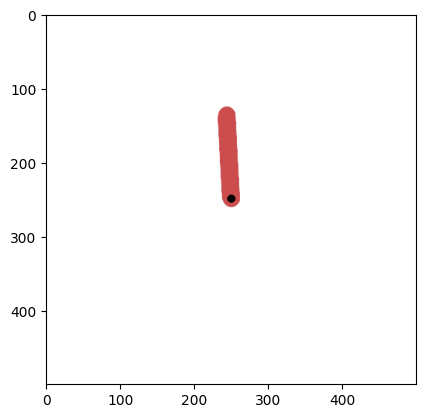

In [9]:
# Render the environment (render is not the observation!) and get width and height
frame = env.render()
width = frame.shape[1]
height = frame.shape[0]

# Show frame
print(frame.shape)
plt.imshow(frame)

In [10]:
# Function that tests the model in the given environment
def test_agent(env, model, max_steps=0, video=None, msg=None):

    # Reset environment
    obs, info = env.reset()
    ep_len = 0
    ep_rew = 0
    avg_step_time = 0.0

    # Run episode until complete
    while True:

        # Provide observation to policy to predict the next action
        timestamp = time.time()
        action, _ = model.predict(obs)

        # Perform action, update total reward
        obs, reward, terminated, truncated, info = env.step(action)
        avg_step_time += time.time() - timestamp
        ep_rew += reward

        # Record frame to video
        if video:
            frame = env.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            frame = cv2.putText(
                frame,                    # Image
                msg,                      # Text to add
                (10, 25),                 # Origin of text in imagg
                cv2.FONT_HERSHEY_SIMPLEX, # Font
                1,                        # Font scale
                (0, 0, 0,),               # Color
                2,                        # Thickness
                cv2.LINE_AA               # Line type
            )
            video.write(frame)

        # Increase step counter
        ep_len += 1
        if (max_steps > 0) and (ep_len >= max_steps):
            break

        # Check to see if episode has ended
        if terminated or truncated:
            break

    # Calculate average step time
    avg_step_time /= ep_len

    return ep_len, ep_rew, avg_step_time

In [11]:
class DummyAgent():
    """
    Agent that just predicts random actions
    """

    # Save environment
    def __init__(self, env):
        self.env = env

    # Always output random action regardless of observation
    def predict(self, obs):
        action = self.env.action_space.sample()
        return action, None

In [12]:
# Recorder settings
FPS = 30
FOURCC = cv2.VideoWriter.fourcc('m', 'p', '4', 'v')
VIDEO_FILENAME = "1-random.mp4"

# Create recorder
video = cv2.VideoWriter(VIDEO_FILENAME, FOURCC, FPS, (width, height))

# Try running a few episodes with the environment and random actions
dummy_agent = DummyAgent(env)
for ep in range(5):
    ep_len, ep_rew, step_time = test_agent(env, dummy_agent, max_steps=100, video=video, msg=f"Random, episode {ep}")
    print(f"Episode {ep} | Length: {ep_len}, Reward: {ep_rew}, Step time: {(step_time * 1000):.2e} ms")

# Close the video writer
video.release()

Episode 0 | Length: 100, Reward: -492.18571178914056, Step time: 2.02e-01 ms
Episode 1 | Length: 100, Reward: -378.5471863724411, Step time: 1.62e-01 ms
Episode 2 | Length: 100, Reward: -499.8621798576484, Step time: 2.04e-01 ms
Episode 3 | Length: 100, Reward: -483.6758040435373, Step time: 1.28e-01 ms
Episode 4 | Length: 100, Reward: -515.4468645790975, Step time: 1.69e-01 ms


## Testing and logging callbacks

Construct custom callbacks for Stable-Baselines3 to test our agent and log metrics to Weights & Biases.

In [13]:
# Evaluate agent on a number of tests
def evaluate_agent(env, model, steps_per_test, num_tests):

    # Initialize metrics
    avg_ep_len = 0
    avg_ep_rew = 0
    avg_step_time = 0.0

    # Test the agent a number of times
    for ep in range(num_tests):
        ep_len, ep_rew, step_time = test_agent(env, model, max_steps=steps_per_test)
        avg_ep_len += ep_len
        avg_ep_rew += ep_rew
        avg_step_time += step_time

    # Compute metrics
    avg_ep_len /= num_tests
    avg_ep_rew /= num_tests
    avg_step_time /= num_tests

    return avg_ep_len, avg_ep_rew, avg_step_time

In [14]:
class EvalAndSaveCallback(BaseCallback):
    """
    Evaluate and save the model every ``check_freq`` steps

    More info: https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html
    """

    # Constructor
    def __init__(
        self,
        check_freq,
        save_dir,
        model_name="model",
        replay_buffer_name=None,
        steps_per_test=0,
        num_tests=10,
        step_offset=0,
        verbose=1,
    ):
        super(EvalAndSaveCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_dir = save_dir
        self.model_name = model_name
        self.replay_buffer_name = replay_buffer_name
        self.num_tests = num_tests
        self.steps_per_test = steps_per_test
        self.step_offset = step_offset
        self.verbose = verbose

    # Create directory for saving the models
    def _init_callback(self):
        if self.save_dir is not None:
            os.makedirs(self.save_dir, exist_ok=True)

    # Save and evaluate model at a set interval
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:

            # Set actual number of steps (including offset)
            actual_steps = self.step_offset + self.n_calls

            # Save model
            model_path = os.path.join(self.save_dir, f"{self.model_name}_{str(actual_steps)}")
            self.model.save(model_path)

            # Save replay buffer
            if self.replay_buffer_name != None:
                replay_buffer_path = os.path.join(self.save_dir, f"{self.replay_buffer_name}")
                self.model.save_replay_buffer(replay_buffer_path)

            # Evaluate the agent
            avg_ep_len, avg_ep_rew, avg_step_time = evaluate_agent(
                env,
                self.model,
                self.steps_per_test,
                self.num_tests
            )
            if self.verbose:
                print(f"{str(actual_steps)} steps | average test length: {avg_ep_len}, average test reward: {avg_ep_rew}")

            # Log metrics to WandB
            log_dict = {
                'avg_ep_len': avg_ep_len,
                'avg_ep_rew': avg_ep_rew,
                'avg_step_time': avg_step_time,
            }
            wandb.log(log_dict, commit=True, step=actual_steps)

        return True

In [15]:
class WandBWriter(KVWriter):
    """
    Log metrics to Weights & Biases when called by .learn()

    More info: https://stable-baselines3.readthedocs.io/en/master/_modules/stable_baselines3/common/logger.html#KVWriter
    """

    # Initialize run
    def __init__(self, run, verbose=1):
        super().__init__()
        self.run = run
        self.verbose = verbose

    # Write metrics to W&B project
    def write(self,
              key_values: Dict[str, Any],
              key_excluded: Dict[str, Union[str, Tuple[str, ...]]],
              step: int = 0) -> None:
        log_dict = {}

        # Go through each key/value pairs
        for (key, value), (_, excluded) in zip(
            sorted(key_values.items()), sorted(key_excluded.items())):

            if self.verbose >= 2:
                print(f"step={step} | {key} : {value} ({type(value)})")

            # Skip excluded items
            if excluded is not None and "wandb" in excluded:
                continue

            # Log integers and floats
            if isinstance(value, np.ScalarType):
                if not isinstance(value, str):
                    wandb.log(data={key: value}, step=step)
                    log_dict[key] = value

        # Print to console
        if self.verbose >= 1:
            print(f"Log for steps={step}")
            print(f"--------------")
            for (key, value) in sorted(log_dict.items()):
                print(f"  {key}: {value}")
            print()

    # Close the W&B run
    def close(self) -> None:
        self.run.finish()

## Define train and test function for a single trial

A single "trial" is fully training and then testing the agent using one set of hyperparameters.

In [16]:
def do_trial(settings, hparams):
    """
    Training loop used to evaluate a set of hyperparameters
    """

    # Set random seed
    set_random_seeds(settings['seed'], using_cuda=th.cuda.is_available())

    # Create new W&B run
    config = {}
    dt = datetime.datetime.now(datetime.timezone.utc)
    dt = dt.replace(microsecond=0, tzinfo=None)
    run = wandb.init(
        project=settings['wandb_project'],
        name=str(dt),
        config=config,
        settings=wandb.Settings(silent=(not settings['verbose_wandb']))
    )

    # Print run info
    if settings['verbose_trial'] > 0:
        print(f"WandB run ID: {run.id}")
        print(f"WandB run name: {run.name}")

    # Log hyperparameters to W&B
    wandb.config.update(hparams)

    # Set custom logger with our custom writer
    wandb_writer = WandBWriter(run, verbose=settings['verbose_log'])
    loggers = Logger(
        folder=None,
        output_formats=[wandb_writer]
    )

    # Calculate derived hyperparameters
    n_steps = 2 ** hparams['steps_per_update_pow2']
    minibatch_size = (hparams['n_envs'] * n_steps) // (2 ** hparams['batch_size_div_pow2'])
    layer_1 = 2 ** hparams['layer_1_pow2']
    layer_2 = 2 ** hparams['layer_2_pow2']


    # Set completed steps to checkpoint number (in filename) or 0 to start over
    # TODO: how to resume if trial is paused?
    completed_steps = 0

    # Load model or create new model
    # PPO docs: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
    # Policy networks: https://stable-baselines.readthedocs.io/en/master/modules/policies.html
    if completed_steps != 0:
        model_path = os.path.join(settings['save_dir'], f"{settings['model_name']}_{str(completed_steps)}.zip")
        model = sb3.PPO.load(model_path, env)
        steps_to_complete = settings['total_steps'] - completed_steps
    else:
        model = sb3.PPO(
            'MlpPolicy',
            env,
            learning_rate=hparams['learning_rate'], # Learning rate of neural network (default: 0.0003)
            n_steps=n_steps,                        # Number of steps per update (default: 2048)
            batch_size=minibatch_size,              # Minibatch size for NN update (default: 64)
            gamma=hparams['gamma'],                 # Discount factor (default: 0.99)
            ent_coef=hparams['entropy_coef'],       # Entropy, how much to explore (default: 0.0)
            use_sde=hparams['use_sde'],             # Use generalized State Dependent Exploration (default: False)
            sde_sample_freq=hparams['sde_freq'],    # Number of steps before sampling new noise matrix (default -1)
            policy_kwargs={'net_arch': [layer_1, layer_2]}, # (default: [64, 64])
            verbose=settings['verbose_train']       # Print training metrics (default: 0)
        )
        steps_to_complete = settings['total_steps']

    # Set up checkpoint callback
    checkpoint_callback = EvalAndSaveCallback(
        check_freq=settings['checkpoint_freq'],
        save_dir=settings['save_dir'],
        model_name=settings['model_name'],
        replay_buffer_name=settings['replay_buffer_name'],
        steps_per_test=settings['steps_per_test'],
        num_tests=settings['tests_per_check'],
        step_offset=(settings['total_steps'] - steps_to_complete),
        verbose=settings['verbose_test'],
    )

    # Choo choo train
    model.learn(total_timesteps=steps_to_complete,
                callback=[checkpoint_callback])

    # Get dataframe of run metrics
    history = wandb.Api().run(f"{run.project}/{run.id}").history()

    # Get index of evaluation with maximum reward
    max_idx = np.argmax(history.loc[:, 'avg_ep_rew'].values)

    # Find number of steps required to produce that maximum reward
    max_rew_steps = history['_step'][max_idx]
    if settings['verbose_trial'] > 0:
        print(f"Steps with max reward: {max_rew_steps}")

    # Load model with maximum reward from previous run
    model_path = os.path.join(settings['save_dir'], f"{settings['model_name']}_{str(max_rew_steps)}.zip")
    model = sb3.PPO.load(model_path, env)

    # Evaluate the agent
    avg_ep_len, avg_ep_rew, avg_step_time = evaluate_agent(
        env,
        model,
        settings['steps_per_test'],
        settings['tests_per_check'],
    )

    # Log final evaluation metrics to WandB run
    wandb.run.summary['Average test episode length'] = avg_ep_len
    wandb.run.summary['Average test episode reward'] = avg_ep_rew
    wandb.run.summary['Average test step time'] = avg_step_time

    # Print final run metrics
    if settings['verbose_trial'] > 0:
        print("---")
        print(f"Best model: {settings['model_name']}_{str(max_rew_steps)}.zip")
        print(f"Average episode length: {avg_ep_len}")
        print(f"Average episode reward: {avg_ep_rew}")
        print(f"Average step time: {avg_step_time}")

    # Close W&B run
    run.finish()

    return avg_ep_rew

## Perform trials

In [17]:
# Project settings that do not change
settings = {
    'wandb_project': "pendulum-ax-test-and-things",
    'model_name': "ppo-pendulum",
    'ax_experiment_name': "ppo-pendulum-experiment",
    'ax_objective_name': "avg_ep_rew",
    'replay_buffer_name': None,
    'save_dir': "checkpoints",
    'checkpoint_freq': 10_000,
    'steps_per_test': 100,
    'tests_per_check': 10,
    'total_steps': 100_000,
    'num_trials': 30,
    'seed': 42,
    'verbose_ax': False,
    'verbose_wandb': False,
    'verbose_train': 0,
    'verbose_log': 0,
    'verbose_test': 0,
    'verbose_trial': 1,
}

In [18]:
# Define hyperparameters we want to optimize
# Ref: https://github.com/facebook/Ax/blob/6443cee30cbf8cec290200a7420a3db08e4b5445/ax/service/ax_client.py#L236
# Example: https://github.com/facebook/Ax/blob/main/tutorials/tune_cnn_service.ipynb
# Hyperparameters: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#stable_baselines3.ppo.PPO
hparams = [
    {
        'name': "n_envs",
        'type': "fixed",
        'value_type': "int",
        'value': 1,
    },
    {
        'name': "learning_rate",
        'type': "range",
        'value_type': "float",
        'bounds': [1e-5, 1e-2],
        'log_scale': True,
    },
    {
        'name': "steps_per_update_pow2",
        'type': "range",
        'value_type': "int",
        'bounds': [6, 12], # Inclusive, 2**n between [64, 4096]
        'log_scale': False,
        'is_ordered': False,
    },
    {
        'name': "batch_size_div_pow2",
        'type': "range",
        'value_type': "int",
        'bounds': [0, 3], # Inclusive, 2**n between [1, 8]
        'log_scale': False,
        'is_ordered': False,
    },
    {
        'name': "gamma",
        'type': "range",
        'value_type': "float",
        'bounds': [0.9, 0.99],
        'log_scale': False,
    },
    {
        'name': "entropy_coef",
        'value_type': "float",
        'type': "range",
        'bounds': [0.0, 0.1],
        'log_scale': False,
    },
    {
        'name': "use_sde",
        'value_type': "bool",
        'type': "choice",
        'values': [True, False],
        'is_ordered': False,
    },
    {
        'name': "sde_freq",
        'type': "range",
        'value_type': "int",
        'bounds': [-1, 8],
        'log_scale': False,
    },
    {
        'name': "layer_1_pow2",
        'type': "range",
        'value_type': "int",
        'bounds': [5, 8], # Inclusive, 2**n between [32, 256]
        'log_scale': False,
        'is_ordered': False,
    },
    {
        'name': "layer_2_pow2",
        'type': "range",
        'value_type': "int",
        'bounds': [5, 8], # Inclusive, 2**n between [32, 256]
        'log_scale': False,
        'is_ordered': False,
    },
]

# Set parameter constraints
# Example: https://github.com/facebook/Ax/issues/621
parameter_constraints = []

In [19]:
# Create our environment
try:
    env.close()
except NameError:
    pass
env = gym.make('Pendulum-v1', render_mode='rgb_array')

In [20]:
# Cosntruct path to Ax experiment snapshot file
ax_snapshot_path = os.path.join(settings['save_dir'], f"{settings['ax_experiment_name']}.json")

In [21]:
# DANGER! Uncomment to delete the experiment file to start over
# os.remove(ax_snapshot_path)

In [22]:
# Load experiment from snapshot if it exists, otherwise create a new one
# Ref: https://ax.dev/versions/0.2.10/api/service.html#ax.service.ax_client.AxClient.create_experiment
if os.path.exists(ax_snapshot_path):
    print(f"Loading experiment from snapshot: {ax_snapshot_path}")
    ax_client = AxClient.load_from_json_file(ax_snapshot_path)
else:
    print(f"Creating new experiment. Snapshot to be saved at {ax_snapshot_path}.")
    ax_client = AxClient(
        random_seed=settings['seed'],
        verbose_logging=settings['verbose_ax'],
    )
    ax_client.create_experiment(
        name=settings['ax_experiment_name'],
        parameters=hparams,
        objective_name=settings['ax_objective_name'],
        minimize=False,
        parameter_constraints=parameter_constraints,
    )

[WARNING 10-11 20:16:46] ax.service.ax_client: Random seed set to 42. Note that this setting only affects the Sobol quasi-random generator and BoTorch-powered Bayesian optimization models. For the latter models, setting random seed to the same number for two optimizations will make the generated trials similar, but not exactly the same, and over time the trials will diverge more.
C:\Users\sgmustadio\anaconda3\envs\pytorch-gpu\lib\site-packages\ax\core\parameter.py:517: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "use_sde". Defaulting to `True` for parameters of `ParameterType` BOOL. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

[INFO 10-11 20:16:46] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[FixedParameter(name='n_envs', parameter_type=INT, value=1), RangeParameter(name='learning_rate', parameter_type=FLOAT, range=[1e-05, 0.01], log_scale=True), RangeParameter(na

Creating new experiment. Snapshot to be saved at checkpoints\ppo-pendulum-experiment.json.


In [23]:
# Choo choo! Perform trials to optimize hyperparameters
while True:

    # Get next hyperparameters and end experiment if we've reached max trials
    next_hparams, trial_index = ax_client.get_next_trial()
    if trial_index >= settings['num_trials']:
        break

    # Show that we're starting a new trial
    if settings['verbose_trial'] > 0:
        print(f"--- Trial {trial_index} ---")

    # Perform trial
    avg_ep_rew = do_trial(settings, next_hparams)
    ax_client.complete_trial(
        trial_index=trial_index,
        raw_data=avg_ep_rew,
    )

    # Save experiment snapshot
    ax_client.save_to_json_file(ax_snapshot_path)

--- Trial 0 ---


WandB run ID: q219vpnp
WandB run name: 2023-10-12 02:16:48


ValueError: Expected parameter loc (Tensor of shape (8, 1)) of distribution Normal(loc: torch.Size([8, 1]), scale: torch.Size([8, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# Close the environment
env.close()

In [ ]:
# Create a dummy run so we can programmatically obtain the W&B username
wandb_api = wandb.Api()
dummy_run = wandb.init()
wandb_entity = wandb.run.entity
dummy_id = dummy_run.id
dummy_run.finish()
# wandb_run = wandb_api.run(f"{wandb_entity}/{settings['wandb_project']}/{dummy_id}")

In [ ]:
# Create a list of average test reward for each trial
runs = wandb_api.runs(path=f"{wandb_entity}/{settings['wandb_project']}")
trial_rews = []
for r in reversed(runs):
    trial_rew = r.summary.get('Average test episode reward')
    if trial_rew is not None:
        trial_rews.append(trial_rew)

# Plot the list of test rewards over time
plt.plot(trial_rews)

## Train agent with best hyperparameters

Note that you may need to manually adjust some of the hyperparameters to make everything work.

In [ ]:
# Get from W&B dashboard
hparams = {
    'n_envs': 1,
    'learning_rate': 0.0078,
    'steps_per_update_pow2': 10,
    'batch_size_div_pow2': 2,
    'gamma': 0.974,
    'entropy_coef': 0.0356,
    'use_sde': True,
    'sde_freq': 4,
    'layer_1_pow2': 5,
    'layer_2_pow2': 8,
}

In [ ]:
# Create our environment
try:
    env.close()
except NameError:
    pass
env = gym.make('Pendulum-v1', render_mode='rgb_array')

In [ ]:
# Train model
_ = do_trial(settings, hparams)

## Test fully trained agent

In [ ]:
# Model and video settings
MODEL_FILENAME = "checkpoints/ppo-pendulum_70000.zip"
VIDEO_FILENAME = "2-testing.mp4"

# Create our environment
try:
    env.close()
except NameError:
    pass
env = gym.make('Pendulum-v1', render_mode='rgb_array')

# Load the model
model = sb3.PPO.load(MODEL_FILENAME)

# Create recorder
video = cv2.VideoWriter(VIDEO_FILENAME, FOURCC, FPS, (width, height))

# Test the model
ep_len, ep_rew, avg_step_time = test_agent(env, model, max_steps=200, video=video, msg=f"{MODEL_FILENAME}")
print(f"Episode length: {ep_len}, reward: {ep_rew}, avg step time: {avg_step_time}")

# Close the video writer
video.release()